In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, shutil, tarfile, requests
import glob
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorboard import notebook
import math
import random
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
from PIL import ImageOps

In [ ]:
tar_file_path = "/content/drive/MyDrive/Projet 6/images/images.tar"
target_directory = "/content/drive/MyDrive/Projet 6/images"

## Code to run once

In [ ]:
import tarfile

def extract_tar_folder(tar_file_path, target_directory):
    # Open the tar file
    with tarfile.open(tar_file_path, 'r') as tar:
        # Extract all the contents of the tar file to the target directory
        tar.extractall(target_directory)

        print("Extraction completed.")

# Call the function to extract the tar folder
extract_tar_folder(tar_file_path, target_directory)


Extraction completed.


In [ ]:
import os

def rename_folders(path):
    # Vérification si le chemin existe et s'il est un répertoire
    if not os.path.exists(path) or not os.path.isdir(path):
        print("Le chemin spécifié n'est pas valide.")
        return

    # Parcourir tous les dossiers dans le chemin
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        # Vérification si le chemin est un dossier
        if os.path.isdir(folder_path):
            # Séparation du nom du dossier par le caractère "-"
            parts = folder_name.split('-')

            # Construction du nouveau nom du dossier
            new_folder_name = parts[-1]  # Récupération du dernier élément de la liste

            # Chemin du nouveau dossier
            new_folder_path = os.path.join(path, new_folder_name)

            # Renommer le dossier
            os.rename(folder_path, new_folder_path)
            print(f"Le dossier {folder_name} a été renommé en {new_folder_name}.")

images_path = "/content/drive/MyDrive/Projet 6/images/Images"

# Appeler la fonction pour renommer les dossiers dans le chemin spécifié
rename_folders(images_path)


Le dossier n02085620-Chihuahua a été renommé en Chihuahua.
Le dossier n02085782-Japanese_spaniel a été renommé en Japanese_spaniel.
Le dossier n02085936-Maltese_dog a été renommé en Maltese_dog.
Le dossier n02086079-Pekinese a été renommé en Pekinese.
Le dossier n02086240-Shih-Tzu a été renommé en Tzu.
Le dossier n02086646-Blenheim_spaniel a été renommé en Blenheim_spaniel.
Le dossier n02086910-papillon a été renommé en papillon.
Le dossier n02087046-toy_terrier a été renommé en toy_terrier.
Le dossier n02087394-Rhodesian_ridgeback a été renommé en Rhodesian_ridgeback.
Le dossier n02088094-Afghan_hound a été renommé en Afghan_hound.
Le dossier n02088238-basset a été renommé en basset.
Le dossier n02088364-beagle a été renommé en beagle.
Le dossier n02088466-bloodhound a été renommé en bloodhound.
Le dossier n02088632-bluetick a été renommé en bluetick.
Le dossier n02089078-black-and-tan_coonhound a été renommé en tan_coonhound.
Le dossier n02089867-Walker_hound a été renommé en Walker_

## Exploration des données

In [4]:
%%time
!cp -r '/content/drive/MyDrive/Projet 6/images/Images' '/content/'

CPU times: user 256 ms, sys: 24.6 ms, total: 280 ms
Wall time: 42 s


In [5]:
IMAGES_PATH = "/content/Images"


In [21]:
race_counts = {}

for breed_dir in os.listdir(IMAGES_PATH):
    breed_name = breed_dir

    breed_dir_path = os.path.join(IMAGES_PATH, breed_dir)
    breed_images = os.listdir(breed_dir_path)
    race_counts[breed_name] = len(breed_images)

# Trier les races par nombre d'images
sorted_races = sorted(race_counts.items(), key=lambda x: x[1], reverse=True)
races, counts = zip(*sorted_races)

# Définir la palette de couleurs personnalisée avec un fondu
palette = px.colors.sequential.Viridis  # Palette de couleurs prédéfinie
num_races = len(races)

custom_colors = []
for i in range(num_races):
    color_index = int(i / num_races * (len(palette) - 1))
    color = palette[color_index]
    custom_colors.append(color)

# Créer la figure Plotly pour l'histogramme
fig = go.Figure(data=[go.Bar(x=races, y=counts, marker_color=custom_colors)])

# Personnaliser l'apparence de l'histogramme
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title="Race de chien",
    yaxis_title="Nombre de photos",
    title="Nombre de photos par race de chien",
    hovermode="closest",
    barmode="stack",
    template="plotly_white"
)

# Afficher l'histogramme interactif
fig.show()

print(f"Nombre de races différentes : {num_races}")

Nombre de races différentes : 119


## Pré-traitement

### Création des générateurs

In [8]:
batch_size = 32
img_height = 224
img_width = 224


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGES_PATH,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
)

Found 20428 files belonging to 119 classes.
Using 16343 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGES_PATH,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
)

Found 20428 files belonging to 119 classes.
Using 4085 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Pomeranian', 'Rhodesian_ridgeback

### Layer de normalisation

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Construction d'un modèle de classification naïf



### Architecture du modèle

In [6]:
num_classes = 119

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./127.5, offset=-1),
  tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
  tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

# optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])


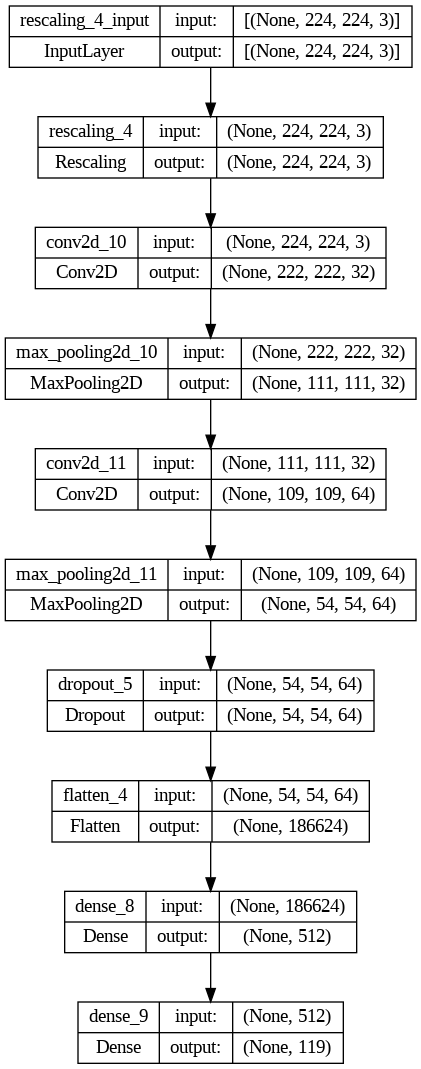

In [41]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True)

### Entrainement du modèle

In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds, use_multiprocessing=True)

Epoch 1/15
511/511 [==============================] - 49s 92ms/step - loss: 4.9726 - accuracy: 0.0121 - val_loss: 4.7765 - val_accuracy: 0.0098
Epoch 2/15
511/511 [==============================] - 47s 92ms/step - loss: 4.7738 - accuracy: 0.0125 - val_loss: 4.7760 - val_accuracy: 0.0098
Epoch 3/15
511/511 [==============================] - 47s 92ms/step - loss: 4.7638 - accuracy: 0.0152 - val_loss: 4.7311 - val_accuracy: 0.0140
Epoch 4/15
511/511 [==============================] - 47s 92ms/step - loss: 4.5262 - accuracy: 0.0482 - val_loss: 4.6518 - val_accuracy: 0.0330
Epoch 5/15
511/511 [==============================] - 47s 91ms/step - loss: 2.9104 - accuracy: 0.3299 - val_loss: 5.6640 - val_accuracy: 0.0330
Epoch 6/15
511/511 [==============================] - 47s 92ms/step - loss: 0.5214 - accuracy: 0.8850 - val_loss: 8.9107 - val_accuracy: 0.0306
Epoch 7/15
511/511 [==============================] - 47s 91ms/step - loss: 0.1130 - accuracy: 0.9871 - val_loss: 9.7577 - val_accuracy:

### Résultats du modèle

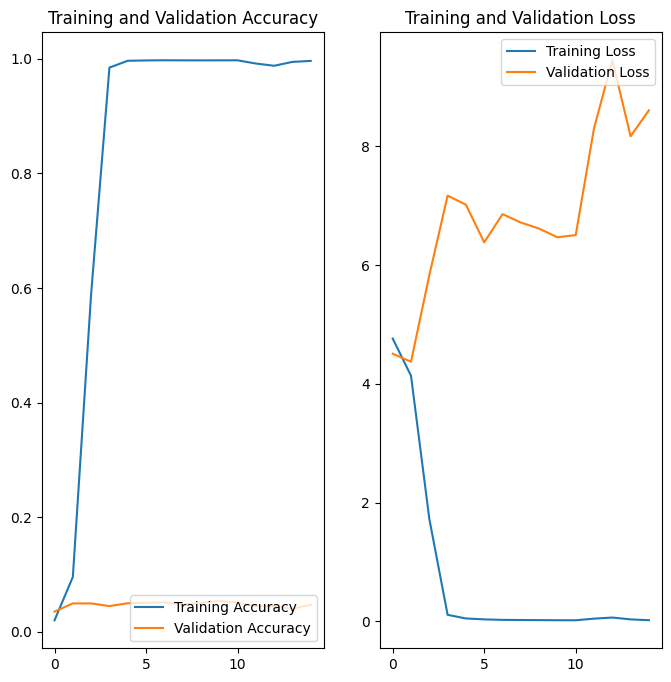

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le modèle de classification naïf présente des problèmes évidents, avec des valeurs d'accuracy très faibles et une capacité limitée à généraliser sur de nouvelles données. La loss reste élevée et augmente sur le jeu de validation, indiquant un surapprentissage du modèle. Les valeurs de val_loss sont également élevées, témoignant d'une difficulté à capturer les motifs distinctifs dans les images.

## Construction d'un modèle optimisé

Afin d'optimiser le modèle, et ainsi empécher que le modèle ne surapprenne, plusieurs solutions sont envisageables :



*   Data Augmentation
*   Optimisation du Learning Rate
*   Réduction du nombre de classes





### Data augmentation

La Data Augmentation est une technique utilisée en apprentissage automatique pour augmenter la taille du dataset en appliquant des transformations aléatoires telles que des rotations, des translations ou des changements d'échelle aux images existantes, ce qui permet d'améliorer la capacité du modèle à généraliser et à éviter le surapprentissage.

In [12]:

data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

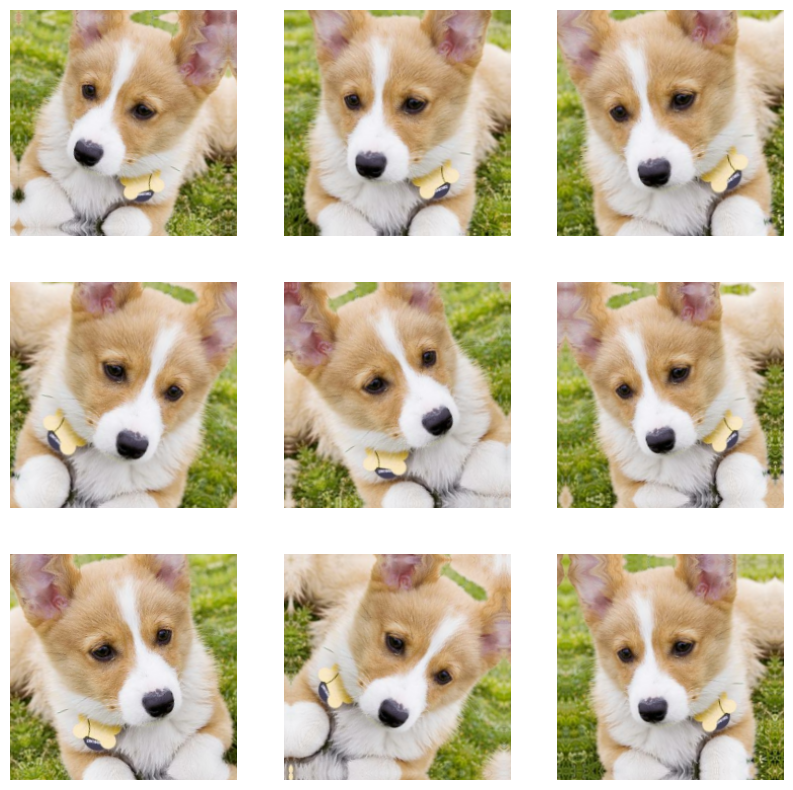

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Ajout de Régularisations et Dropout

L'optimisation du learning rate est un processus essentiel dans l'entraînement des modèles d'apprentissage automatique. L'utilisation de techniques telles que le dropout et le kernel_regularizer_l2 permet de régulariser le modèle en introduisant des contraintes sur les poids. Le dropout désactive aléatoirement des neurones lors de l'entraînement, ce qui réduit la dépendance entre les neurones et améliore la généralisation. Le kernel_regularizer_l2 applique une pénalité L2 sur les poids du modèle, ce qui encourage les poids à être petits et réguliers, limitant ainsi le surapprentissage. Ces techniques, combinées à une optimisation appropriée du learning rate, contribuent à obtenir des modèles plus robustes et performants.

#### Architecture

In [13]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

augmented_model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./127.5, offset=-1),
  Conv2D(32, 3, activation='relu', kernel_regularizer=l2(0.001)),
  MaxPooling2D(pool_size=2, strides=2),
  Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.001)),
  MaxPooling2D(pool_size=2, strides=2),
  Conv2D(128, 3, activation='relu', kernel_regularizer=l2(0.001)),
  MaxPooling2D(pool_size=2, strides=2),
  Dropout(0.2),
  Flatten(),
  Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
  Dense(119, activation='softmax')
])


augmented_model.compile(
  optimizer="adam",
  loss=tf.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

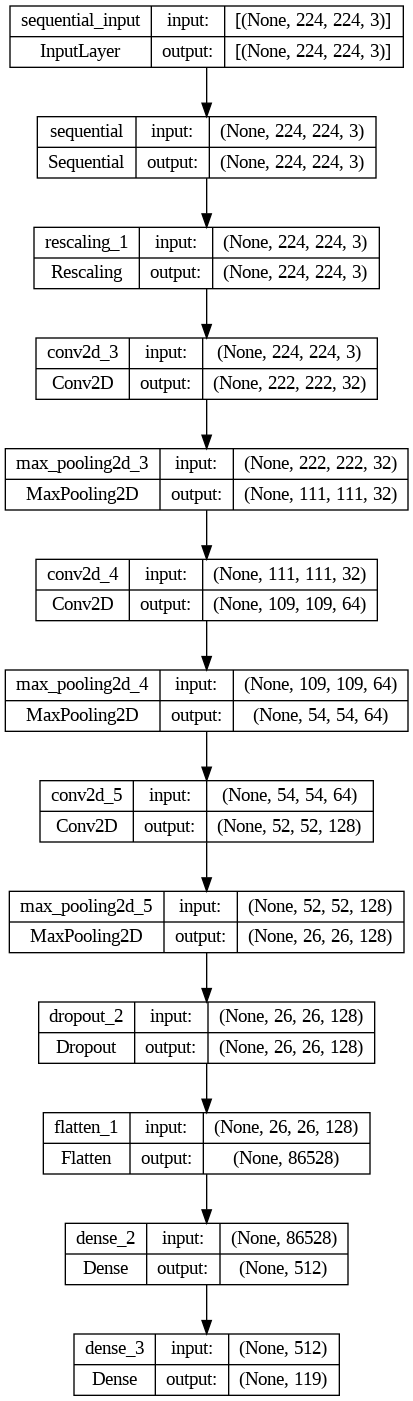

In [43]:
plot_model(augmented_model, to_file='model_architecture.png', show_shapes=True)

#### Entraînement

In [17]:
augmented_history = augmented_model.fit(train_ds, epochs=60, validation_data=val_ds, use_multiprocessing=True)


Epoch 1/60
511/511 [==============================] - 53s 99ms/step - loss: 5.0365 - accuracy: 0.0100 - val_loss: 4.8328 - val_accuracy: 0.0105
Epoch 2/60
511/511 [==============================] - 50s 98ms/step - loss: 4.8148 - accuracy: 0.0130 - val_loss: 4.8066 - val_accuracy: 0.0098
Epoch 3/60
511/511 [==============================] - 50s 99ms/step - loss: 4.7361 - accuracy: 0.0175 - val_loss: 4.6345 - val_accuracy: 0.0257
Epoch 4/60
511/511 [==============================] - 50s 98ms/step - loss: 4.6212 - accuracy: 0.0244 - val_loss: 4.6102 - val_accuracy: 0.0264
Epoch 5/60
511/511 [==============================] - 49s 96ms/step - loss: 4.5835 - accuracy: 0.0305 - val_loss: 4.5713 - val_accuracy: 0.0313
Epoch 6/60
511/511 [==============================] - 49s 96ms/step - loss: 4.5560 - accuracy: 0.0291 - val_loss: 4.5372 - val_accuracy: 0.0301
Epoch 7/60
511/511 [==============================] - 49s 96ms/step - loss: 4.5411 - accuracy: 0.0319 - val_loss: 4.5339 - val_accuracy:

#### Résultats

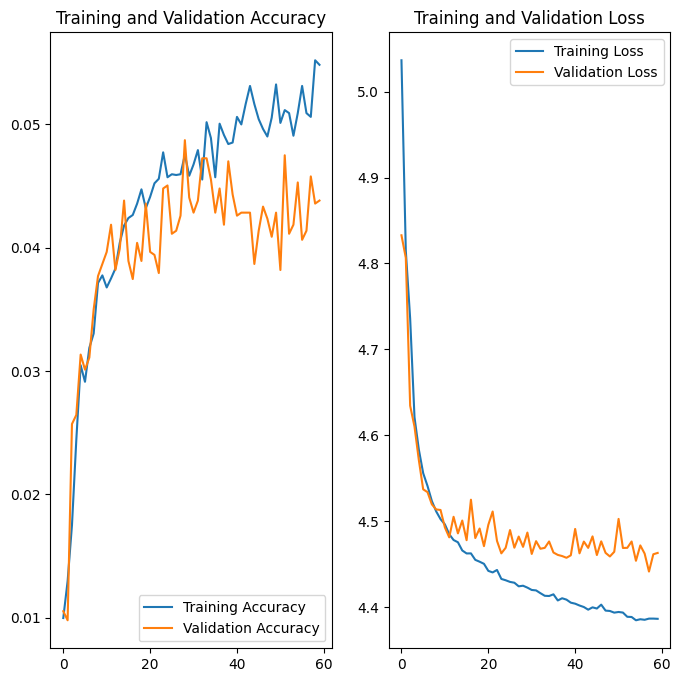

In [18]:
import matplotlib.pyplot as plt

acc_augmented = augmented_history.history['accuracy']
val_acc_augmented = augmented_history.history['val_accuracy']

loss_augmented = augmented_history.history['loss']
val_loss_augmented = augmented_history.history['val_loss']

epochs_range = range(60)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_augmented, label='Training Accuracy')
plt.plot(epochs_range, val_acc_augmented, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_augmented, label='Training Loss')
plt.plot(epochs_range, val_loss_augmented, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Les résultats obtenus avec l'optimisation du learning rate, l'utilisation de dropout et kernel_regularizer_l2 montrent une légère amélioration par rapport aux résultats précédents. L'accuracy et la val_accuracy augmentent progressivement au fil des epochs, bien que les valeurs restent relativement faibles. Cependant, la val_loss diminue également, indiquant une meilleure performance du modèle sur le jeu de validation.

Il est important de noter que ces améliorations ne parviennent pas à surmonter complètement les limitations du dataset limité de 119 classes avec seulement 20 000 images. La diversité et la quantité de données par classe peuvent encore poser des défis à la capacité du modèle à apprendre de manière précise et à généraliser efficacement. Une augmentation plus significative du dataset ou l'utilisation de techniques de transfert learning pourraient aider à améliorer davantage les performances du modèle.

En conclusion, bien que l'optimisation du learning rate, le dropout et le kernel_regularizer_l2 aient apporté des améliorations modestes, la taille restreinte du dataset continue d'être un facteur limitant dans la performance du modèle de classification d'image.



## Construction du modèle sur dataset réduit

Dans le but d'évaluer l'impact de la réduction du nombre de classes et de la concentration sur les classes les plus représentées, nous avons effectué un test en ne considérant que les 10 classes les plus fréquentes dans le dataset.

### Création du nouveau répertoire

In [22]:
import os
import shutil
import operator

# Nombre de races à sélectionner
num_selected_races = 10

# Trier le dictionnaire par nombre d'images dans l'ordre décroissant
sorted_races = sorted(race_counts.items(), key=operator.itemgetter(1), reverse=True)

# Sélectionner les noms des races avec le plus grand nombre d'images
selected_races = [race for race, _ in sorted_races[:num_selected_races]]

# Chemin du répertoire des images sélectionnées
SELECTED_IMAGES_PATH = "/content/Selected_Images"

In [24]:
# Créer le répertoire des images sélectionnées s'il n'existe pas déjà
os.makedirs(SELECTED_IMAGES_PATH, exist_ok=True)

# Copier les dossiers correspondant aux races sélectionnées
for race in selected_races:
    source_folder = os.path.join(IMAGES_PATH, race)
    destination_folder = os.path.join(SELECTED_IMAGES_PATH, race)
    shutil.copytree(source_folder, destination_folder)

### Création des générateurs

In [25]:
selected_train_ds = tf.keras.utils.image_dataset_from_directory(
    SELECTED_IMAGES_PATH,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
)


Found 2233 files belonging to 10 classes.
Using 1787 files for training.


In [26]:
selected_val_ds = tf.keras.utils.image_dataset_from_directory(
    SELECTED_IMAGES_PATH,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
)

Found 2233 files belonging to 10 classes.
Using 446 files for validation.


In [27]:
selected_class_names = selected_train_ds.class_names
print(selected_class_names)

['Afghan_hound', 'Bernese_mountain_dog', 'Great_Pyrenees', 'Irish_wolfhound', 'Leonberg', 'Maltese_dog', 'Pomeranian', 'Samoyed', 'Scottish_deerhound', 'Tzu']


### Architecture du modèle

In [31]:
num_selected_classes = 10

selected_model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./127.5, offset=-1),
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
  tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(num_selected_classes, activation='softmax')
])

selected_model.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])


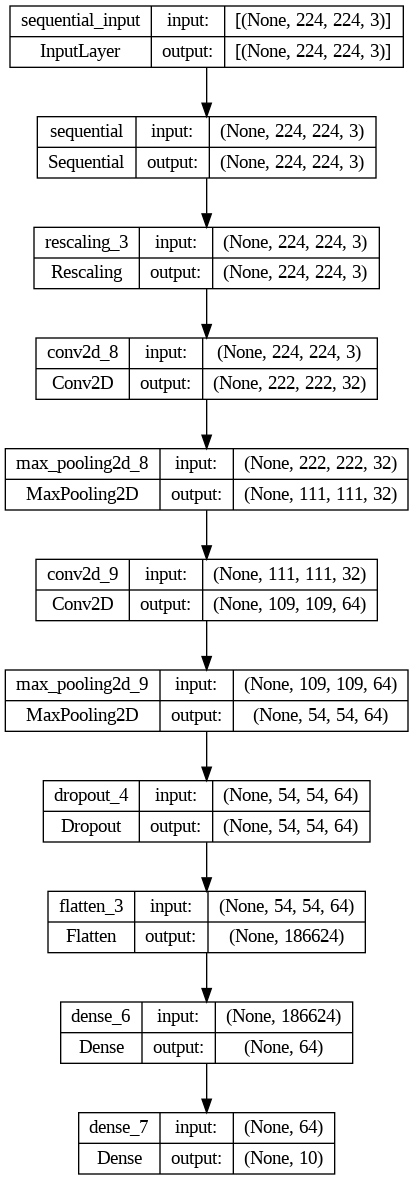

In [44]:
plot_model(selected_model, to_file='model_architecture.png', show_shapes=True)

### Entrainement du modèle

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

selected_train_ds = selected_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
selected_val_ds = selected_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
selected_history = selected_model.fit(selected_train_ds, epochs=30, validation_data=selected_val_ds, use_multiprocessing=True)

Epoch 1/30
56/56 [==============================] - 7s 83ms/step - loss: 2.5929 - accuracy: 0.1757 - val_loss: 2.2010 - val_accuracy: 0.2108
Epoch 2/30
56/56 [==============================] - 4s 80ms/step - loss: 2.1030 - accuracy: 0.2602 - val_loss: 2.1086 - val_accuracy: 0.2265
Epoch 3/30
56/56 [==============================] - 4s 79ms/step - loss: 1.9922 - accuracy: 0.3111 - val_loss: 1.9605 - val_accuracy: 0.2982
Epoch 4/30
56/56 [==============================] - 4s 79ms/step - loss: 1.8900 - accuracy: 0.3380 - val_loss: 2.1952 - val_accuracy: 0.2601
Epoch 5/30
56/56 [==============================] - 4s 79ms/step - loss: 1.8267 - accuracy: 0.3710 - val_loss: 1.9594 - val_accuracy: 0.3229
Epoch 6/30
56/56 [==============================] - 4s 79ms/step - loss: 1.7548 - accuracy: 0.4001 - val_loss: 1.9208 - val_accuracy: 0.3251
Epoch 7/30
56/56 [==============================] - 4s 79ms/step - loss: 1.6893 - accuracy: 0.4113 - val_loss: 1.8977 - val_accuracy: 0.3274
Epoch 8/30
56

### Résultats

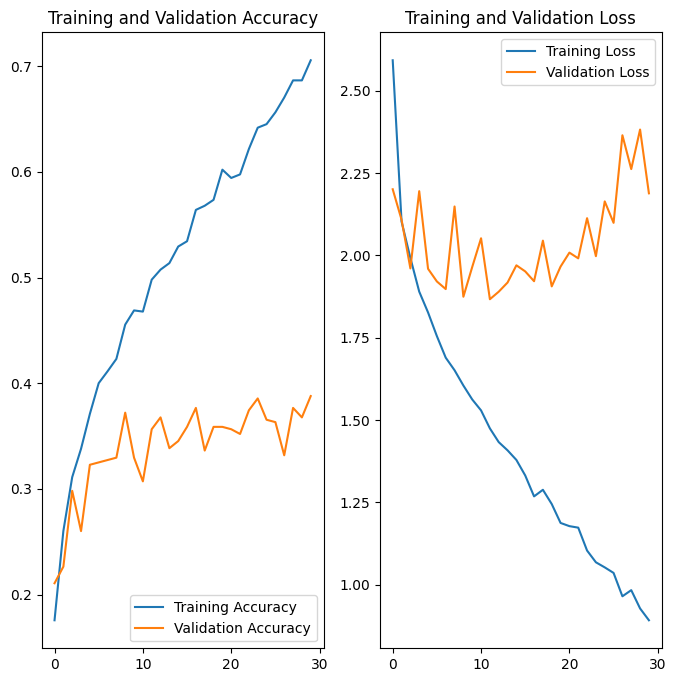

In [35]:
import matplotlib.pyplot as plt

acc_selected = selected_history.history['accuracy']
val_acc_selected = selected_history.history['val_accuracy']

loss_selected = selected_history.history['loss']
val_loss_selected = selected_history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_selected, label='Training Accuracy')
plt.plot(epochs_range, val_acc_selected, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_selected, label='Training Loss')
plt.plot(epochs_range, val_loss_selected, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Les résultats du modèle réduit avec seulement les 10 classes les plus représentées montrent une amélioration significative par rapport aux résultats précédents. L'accuracy et la val_accuracy augmentent progressivement au cours des epochs, atteignant une précision de 38.79% sur le jeu de validation. Cependant, malgré cette amélioration, la performance du modèle reste relativement limitée, ce qui suggère que la taille réduite du dataset continue d'être un facteur contraignant dans la classification précise des races de chiens.

## Utilisation de modèle de Transfer Learning

Le transfer learning est une technique qui consiste à utiliser des modèles pré-entraînés sur de grandes quantités de données pour résoudre des problèmes similaires. Cela peut être extrêmement utile lorsque nous disposons d'un petit jeu de données, car le modèle pré-entraîné a déjà appris des caractéristiques générales sur des images complexes, ce qui peut accélérer l'apprentissage et améliorer les performances.

En conclusion, le transfer learning est une technique puissante pour tirer parti de modèles pré-entraînés, en particulier lorsque les données sont limitées. VGG16 et ResNet50 sont deux choix solides pour des problèmes de classification d'images, chacun avec ses propres caractéristiques et avantages.

### VGG16

VGG16, il est apprécié pour sa simplicité et sa facilité d'interprétation. Il utilise des convolutions de taille 3x3 et des couches entièrement connectées pour extraire les caractéristiques des images.

### ResNet50


ResNet50 utilise des blocs résiduels qui aident à résoudre le problème de disparition des gradients dans les réseaux très profonds. Cela permet à ResNet50 d'obtenir de meilleures performances sur des tâches complexes et de gérer des architectures plus profondes.

#### Architecture

In [54]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Charger le modèle ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Ajouter les nouvelles couches pour la classification des races de chiens
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Définir le nouveau modèle
resnet_model = Model(inputs=base_model.input, outputs=predictions)

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


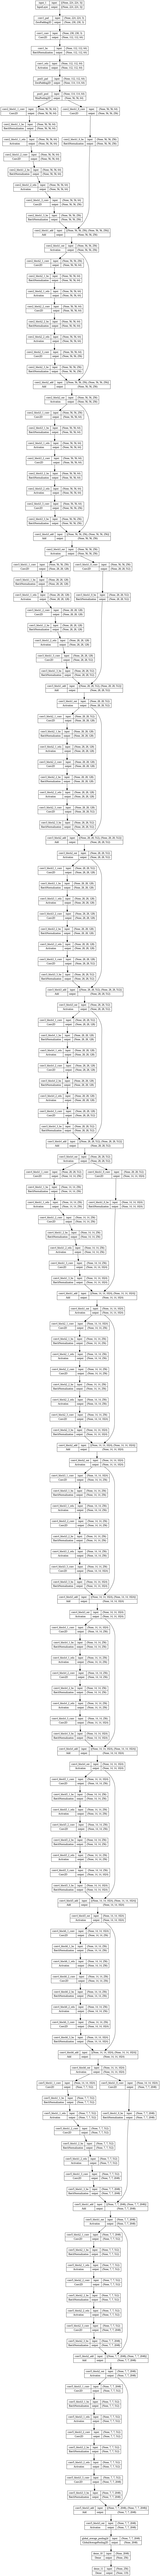

In [46]:
plot_model(resnet_model, to_file='model_architecture.png', show_shapes=True)

#### Entrainement

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
resnet_history = resnet_model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    use_multiprocessing=True
)

Epoch 1/15
511/511 [==============================] - 66s 122ms/step - loss: 1.8874 - accuracy: 0.4991 - val_loss: 1.2885 - val_accuracy: 0.6105
Epoch 2/15
511/511 [==============================] - 61s 119ms/step - loss: 0.9444 - accuracy: 0.7121 - val_loss: 1.1413 - val_accuracy: 0.6548
Epoch 3/15
511/511 [==============================] - 61s 119ms/step - loss: 0.7087 - accuracy: 0.7747 - val_loss: 1.1531 - val_accuracy: 0.6644
Epoch 4/15
511/511 [==============================] - 61s 119ms/step - loss: 0.5434 - accuracy: 0.8266 - val_loss: 1.1118 - val_accuracy: 0.6800
Epoch 5/15
511/511 [==============================] - 61s 119ms/step - loss: 0.4340 - accuracy: 0.8590 - val_loss: 1.2644 - val_accuracy: 0.6580
Epoch 6/15
511/511 [==============================] - 61s 120ms/step - loss: 0.3203 - accuracy: 0.8966 - val_loss: 1.2716 - val_accuracy: 0.6754
Epoch 7/15
511/511 [==============================] - 60s 118ms/step - loss: 0.2534 - accuracy: 0.9190 - val_loss: 1.2565 - val_ac

#### Résultats

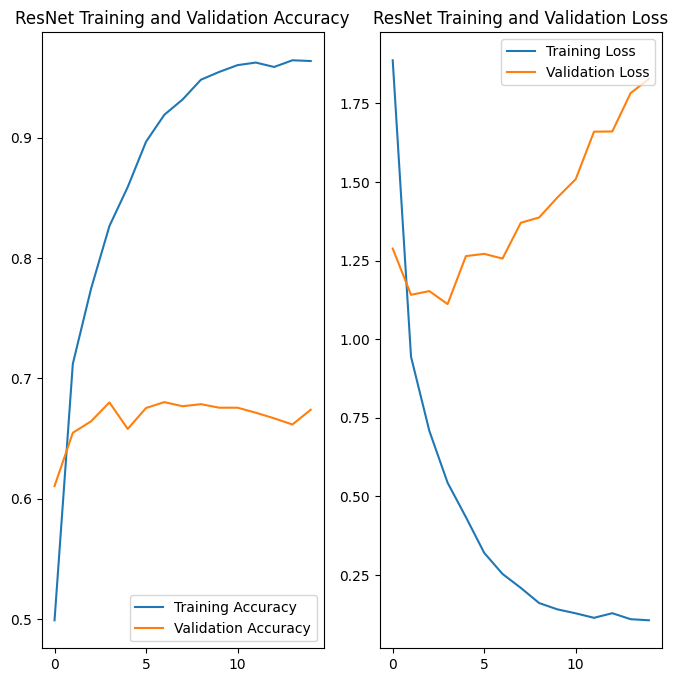

In [57]:
acc_resnet = resnet_history.history['accuracy']
val_acc_resnet = resnet_history.history['val_accuracy']

loss_resnet = resnet_history.history['loss']
val_loss_resnet = resnet_history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_resnet, label='Training Accuracy')
plt.plot(epochs_range, val_acc_resnet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ResNet Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_resnet, label='Training Loss')
plt.plot(epochs_range, val_loss_resnet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('ResNet Training and Validation Loss')
plt.show()


L'analyse des résultats du modèle ResNet-50 montre une amélioration progressive de la précision et une diminution de la perte à mesure que les époques avancent sur le jeu d'entraînement. Cependant, les performances sur le jeu de validation atteignent un plateau autour de 67-68% de précision.



## Sélection du modèle

Le modèle ResNet-50 est une solution prometteuse pour la classification des races de chiens en raison de sa capacité à capturer des caractéristiques complexes des images. Malgré la limitation du dataset relativement restreint avec 119 classes, le modèle a montré une capacité d'apprentissage et a atteint une précision décente. En utilisant le transfert learning, le modèle peut bénéficier de la connaissance préalable acquise lors de l'entraînement sur le vaste ensemble de données ImageNet, ce qui lui permet de généraliser et de reconnaître les caractéristiques spécifiques des races de chiens dans notre tâche de classification.

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGES_PATH,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGES_PATH,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation='mitchellcubic',
    crop_to_aspect_ratio=True,
)


Found 20428 files belonging to 119 classes.
Using 16343 files for training.
Found 20428 files belonging to 119 classes.
Using 4085 files for validation.


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Charger le modèle ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Ajouter les nouvelles couches pour la classification des races de chiens
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Définir le nouveau modèle
final_model = Model(inputs=base_model.input, outputs=predictions)

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
final_history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping]
)

# Save the trained model
final_model.save('resnet_model.h5')

Epoch 1/15
511/511 [==============================] - 243s 126ms/step - loss: 2.3471 - accuracy: 0.3967 - val_loss: 1.3809 - val_accuracy: 0.5865
Epoch 2/15
511/511 [==============================] - 61s 119ms/step - loss: 1.3010 - accuracy: 0.6193 - val_loss: 1.1996 - val_accuracy: 0.6355
Epoch 3/15
511/511 [==============================] - 62s 121ms/step - loss: 1.0259 - accuracy: 0.6938 - val_loss: 1.1282 - val_accuracy: 0.6546
Epoch 4/15
511/511 [==============================] - 61s 119ms/step - loss: 0.8333 - accuracy: 0.7500 - val_loss: 1.2129 - val_accuracy: 0.6507
Epoch 5/15
511/511 [==============================] - 62s 121ms/step - loss: 0.6752 - accuracy: 0.7936 - val_loss: 1.1572 - val_accuracy: 0.6783
Epoch 6/15
511/511 [==============================] - 61s 119ms/step - loss: 0.5458 - accuracy: 0.8291 - val_loss: 1.3128 - val_accuracy: 0.6536


#### Résultats

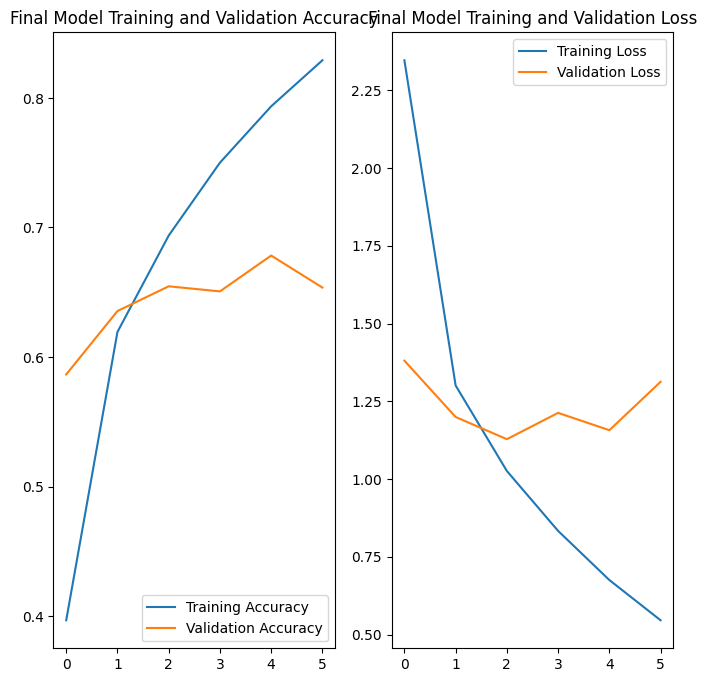

In [20]:
import matplotlib.pyplot as plt

acc_final = final_model.history.history['accuracy']
val_acc_final = final_model.history.history['val_accuracy']

loss_final = final_model.history.history['loss']
val_loss_final = final_model.history.history['val_loss']

epochs_range = range(len(acc_final))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_final, label='Training Accuracy')
plt.plot(epochs_range, val_acc_final, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Final Model Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_final, label='Training Loss')
plt.plot(epochs_range, val_loss_final, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Final Model Training and Validation Loss')
plt.show()


## Sauvegarde du modèle

In [21]:
# Define the path to save the model
save_path = '/content/drive/MyDrive/Projet 6/resnet_model.h5'

# Save the model
final_model.save(save_path)